#**WQU Capstone**
**Group Number: 5468**


*   Track 1: Commodities - Research
*   Topic 1: Energy Products Relationships in Different Markets
*   Title: Understanding and Analyzing Energy Product Price Relationships Across Global Markets







In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from arch import arch_model

#**STEP 1: Data Collection**


*   Collect historical price data for crude oil  (such as WTI, Bonny Light, Brent  etc) and their refined products (such as gasoline, diesel ect) from reliable sources.
*   Official websites and databases will be used.

In [ ]:
def collect_data():
    import pandas as pd

    # Load data from CSV files
    BFOE = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/BFOE.csv?token=GHSAT0AAAAAACRJ326QD7DUOPOWLAPY2A5EZRGP2TQ'
    BFOE_df = pd.read_csv(BFOE, index_col=0, parse_dates=[0])
    Bonny_Light = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Bonny_Light.csv?token=GHSAT0AAAAAACRJ326QMHRKWABVNAUN4Z24ZRGP4JA'
    Bonny_Light_df = pd.read_csv(Bonny_Light, index_col=0, parse_dates=[0])
    Europe_Brent = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Europe_Brent.csv?token=GHSAT0AAAAAACRJ326RYZSDV4PZMXOZPUCUZRGP6FQ'
    Europe_Brent_df = pd.read_csv(Europe_Brent, skiprows=4, index_col=0, parse_dates=[0])
    WTI = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/WTI.csv?token=GHSAT0AAAAAACRJ326QMOYY4U6TIV5QWBXOZRGP74Q'
    WTI_df = pd.read_csv(WTI, skiprows=4, index_col=0, parse_dates=[0])
    Conventional_Gasoline = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Conventional_Gasoline.csv?token=GHSAT0AAAAAACRJ326QGCZTJK7GEZOQWLF4ZRGQARQ'
    Conventional_Gasoline_df = pd.read_csv(Conventional_Gasoline, index_col=0, parse_dates=[0])
    Diesel_Fuel = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Diesel_Fuel.csv?token=GHSAT0AAAAAACRJ326QBCYG26A35TOPUYKIZRGQBNA'
    Diesel_Fuel_df = pd.read_csv(Diesel_Fuel, index_col=0, parse_dates=[0])
    Heating_Oil = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Heating_Oil.csv?token=GHSAT0AAAAAACRJ326RXVM5ZGVAI4H7DR26ZRGQCSA'
    Heating_Oil_df = pd.read_csv(Heating_Oil, index_col=0, parse_dates=[0])
    Propane = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Propane.csv?token=GHSAT0AAAAAACRJ326RRP2E7SP4W77EKHKWZRGQDKQ'
    Propane_df = pd.read_csv(Propane, index_col=0, parse_dates=[0])
    Regular_Gasoline = 'https://raw.githubusercontent.com/shivanivermapro/WQU-Capstone-Project/main/Regular_Gasoline.csv?token=GHSAT0AAAAAACRJ326RQBEAYV2VE3OATFBGZRGQD7Q'
    Regular_Gasoline_df = pd.read_csv(Regular_Gasoline, index_col=0, parse_dates=[0])

    # Convert 'Date' column to datetime format
    BFOE_df.index = pd.to_datetime(BFOE_df.index)
    Europe_Brent_df.index = pd.to_datetime(Europe_Brent_df.index)
    WTI_df.index = pd.to_datetime(WTI_df.index)
    Conventional_Gasoline_df.index = pd.to_datetime(Conventional_Gasoline_df.index)
    Diesel_Fuel_df.index = pd.to_datetime(Diesel_Fuel_df.index)
    Heating_Oil_df.index = pd.to_datetime(Heating_Oil_df.index)
    Propane_df.index = pd.to_datetime(Propane_df.index)
    Regular_Gasoline_df.index = pd.to_datetime(Regular_Gasoline_df.index)

    # Filter data based on date range
    BFOE_df = BFOE_df.loc['2010-01-01':'2024-12-31']
    Bonny_Light_df = Bonny_Light_df.loc['2010-01-01':'2024-12-31']
    Europe_Brent_df = Europe_Brent_df.loc['2010-01-01':'2024-12-31']
    WTI_df = WTI_df.loc['2010-01-01':'2024-12-31']
    Conventional_Gasoline_df = Conventional_Gasoline_df.loc['2010-01-01':'2024-12-31']
    Diesel_Fuel_df = Diesel_Fuel_df.loc['2010-01-01':'2024-12-31']
    Heating_Oil_df = Heating_Oil_df.loc['2010-01-01':'2024-12-31']
    Propane_df = Propane_df.loc['2010-01-01':'2024-12-31']
    Regular_Gasoline_df = Regular_Gasoline_df.loc['2010-01-01':'2024-12-31']

    return BFOE_df, Bonny_Light_df, Europe_Brent_df, WTI_df, Conventional_Gasoline_df, Diesel_Fuel_df, Heating_Oil_df, Propane_df, Regular_Gasoline_df

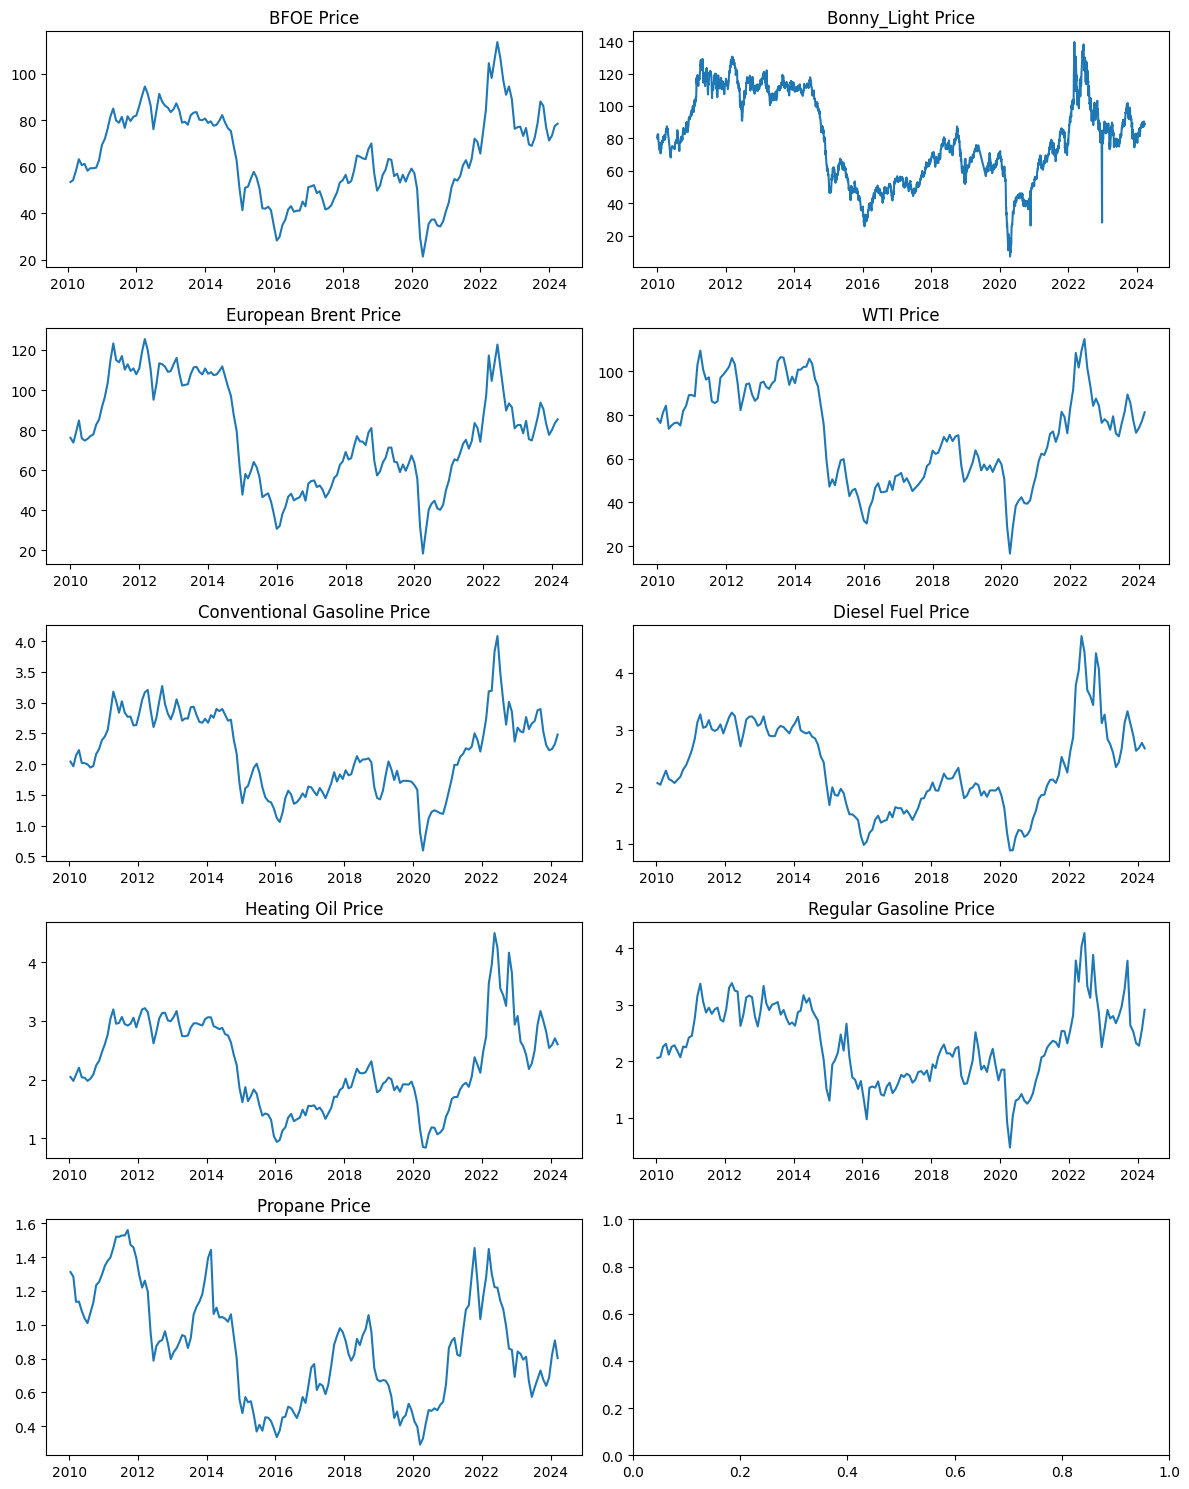

In [ ]:
# Call the function to collect data
BFOE_df, Bonny_Light_df, Europe_Brent_df, WTI_df, Conventional_Gasoline_df, Diesel_Fuel_df, Heating_Oil_df, Propane_df, Regular_Gasoline_df = collect_data()

# Subplots
fig, axs = plt.subplots(5, 2, figsize=(12, 15))

axs[0, 0].plot(BFOE_df.index, BFOE_df['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price'])
axs[0, 0].set_title('BFOE Price')

axs[0, 1].plot(Bonny_Light_df.index, Bonny_Light_df['Crude Oil Price in USD'])
axs[0, 1].set_title('Bonny_Light Price')

axs[1, 0].plot(Europe_Brent_df.index, Europe_Brent_df['Europe Brent Spot Price FOB Dollars per Barrel'])
axs[1, 0].set_title('European Brent Price')

axs[1, 1].plot(WTI_df.index, WTI_df['Cushing OK WTI Spot Price FOB Dollars per Barrel'])
axs[1, 1].set_title('WTI Price')

axs[2, 0].plot(Conventional_Gasoline_df.index, Conventional_Gasoline_df['New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)'])
axs[2, 0].set_title('Conventional Gasoline Price')

axs[2, 1].plot(Diesel_Fuel_df.index, Diesel_Fuel_df['New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)'])
axs[2, 1].set_title('Diesel Fuel Price')

axs[3, 0].plot(Heating_Oil_df.index, Heating_Oil_df['New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)'])
axs[3, 0].set_title('Heating Oil Price')

axs[4, 0].plot(Propane_df.index, Propane_df['Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)'])
axs[4, 0].set_title('Propane Price')

axs[3, 1].plot(Regular_Gasoline_df.index, Regular_Gasoline_df['Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)'])
axs[3, 1].set_title('Regular Gasoline Price')

plt.tight_layout()
plt.show()


#**STEP 2: Data Preprocessing**


*   Clean & validate the data.
*   This includes handling missing values, and ensuring consistency.

In [ ]:
def preprocess_data(df, zero_handling=[], negative_handling=[], blank_handling='ffill', outlier_threshold=3):
    """
    Preprocesses the DataFrame by handling zero values, negative values, blank values, outliers, and NaN values.

    Parameters:
        df (DataFrame): Input DataFrame to be preprocessed.
        zero_handling (list): List of columns with zero values to be handled.
        negative_handling (list): List of columns with negative values to be handled.
        blank_handling (str): Method to handle blank values, options: 'ffill' (forward fill), 'bfill' (backward fill), 'mean' (fill with mean).
        outlier_threshold (float): Threshold value for determining outliers based on z-score.

    Returns:
        DataFrame: Preprocessed DataFrame.
    """
    # Handle NaN values
    df.fillna(method=blank_handling, inplace=True)

    # Handle zero values
    if zero_handling:
        for col in zero_handling:
            df[col] = df[col].replace(0, df[col].mean())

    # Handle negative values
    if negative_handling:
        for col in negative_handling:
            df[col] = df[col].apply(lambda x: max(0, x))

    # Define function for handling outliers
    def handle_outliers(series):
        """
        Replace outliers in the series with the mean value.

        Parameters:
            series (Series): Input Series to be processed.

        Returns:
            Series: Processed Series with outliers replaced by mean.
        """
        # Convert series to numeric values, coercing non-numeric values to NaN
        series_numeric = pd.to_numeric(series, errors='coerce')
        # Fill NaN values with 0.0
        series_numeric.fillna(0.0, inplace=True)
        # Compute percentage change
        series_pct_change = series_numeric.pct_change().fillna(0.0)
        # Compute mean and standard deviation
        mean = series_pct_change.mean()
        std = series_pct_change.std()
        # Compute z-score
        z_score = (series_pct_change - mean) / std
        # Replace outliers with the mean value
        series_pct_change[abs(z_score) > outlier_threshold] = mean
        return series_pct_change

    # Handle outliers
    for col in df.columns:
        df[col] = handle_outliers(df[col])

    return df

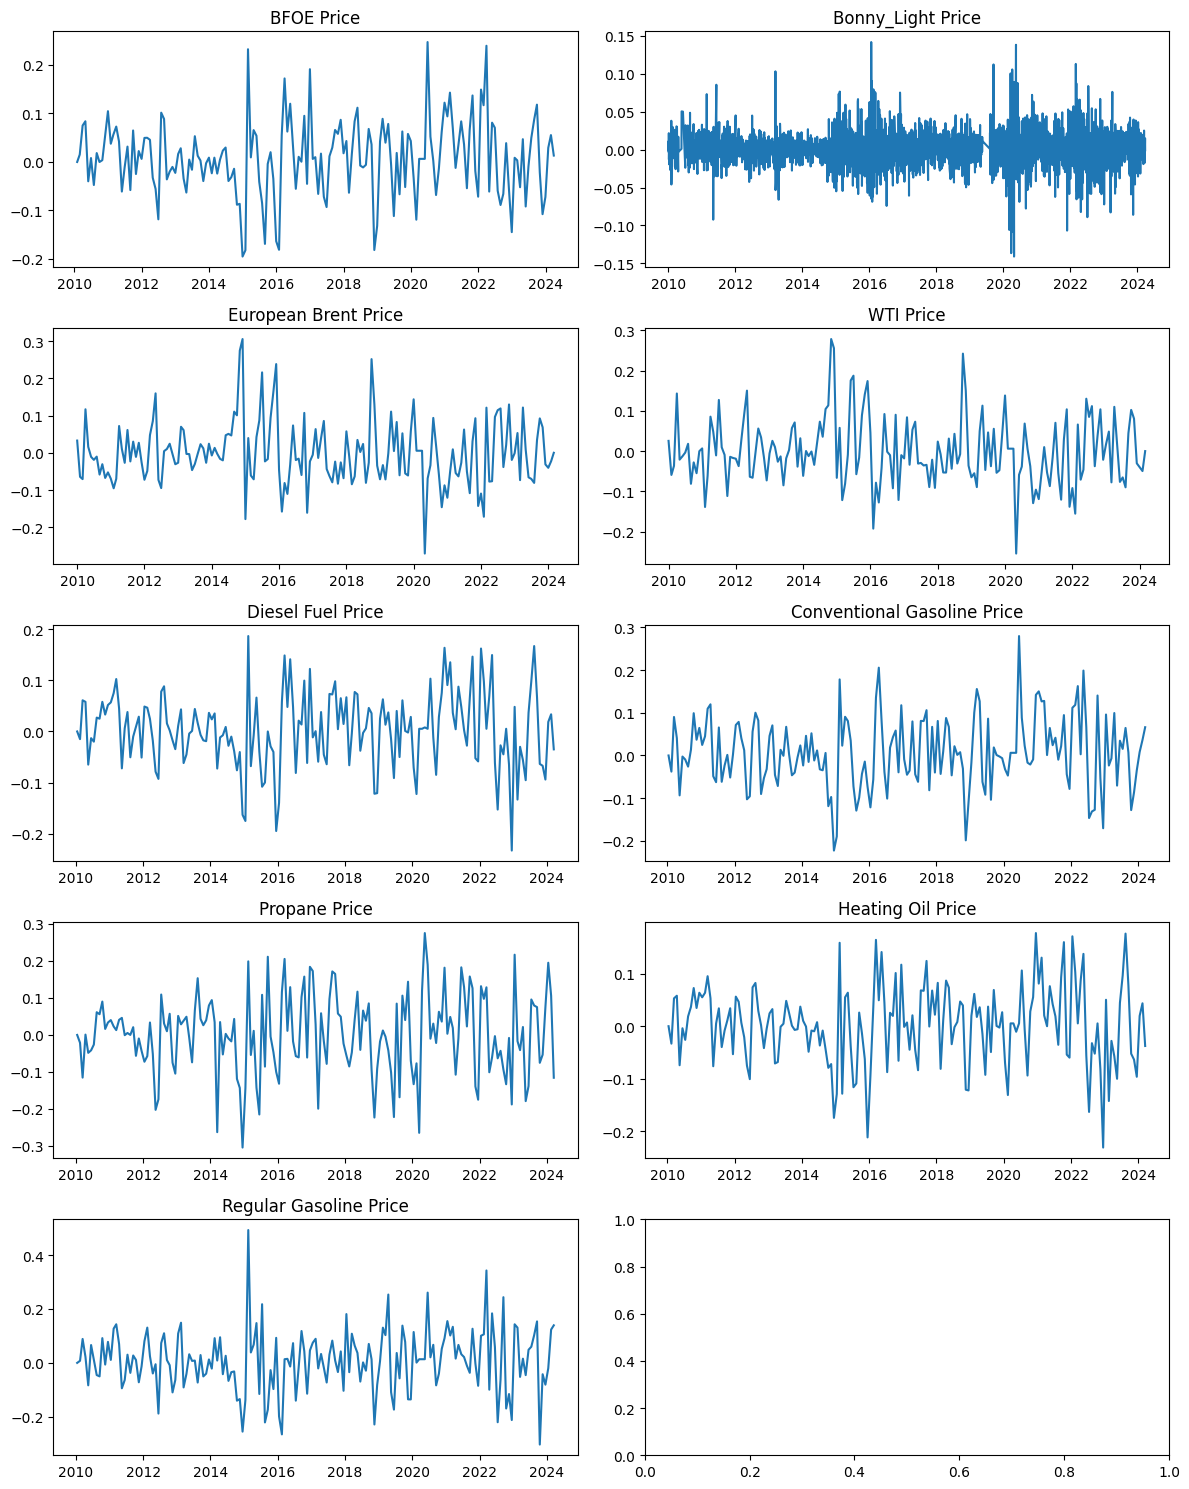

In [ ]:
# Preprocessed data
BFOE_df_processed = preprocess_data(BFOE_df)
Bonny_Light_df_processed = preprocess_data(Bonny_Light_df)
Europe_Brent_df_processed = preprocess_data(Europe_Brent_df)
WTI_df_processed = preprocess_data(WTI_df)
Conventional_Gasoline_df_processed = preprocess_data(Conventional_Gasoline_df)
Diesel_Fuel_df_processed = preprocess_data(Diesel_Fuel_df)
Heating_Oil_df_processed = preprocess_data(Heating_Oil_df)
Propane_df_processed = preprocess_data(Propane_df)
Regular_Gasoline_df_processed = preprocess_data(Regular_Gasoline_df)

# Plot processed data
fig, axs = plt.subplots(5, 2, figsize=(12, 15))

axs[0, 0].plot(BFOE_df_processed.index, BFOE_df_processed['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price'])
axs[0, 0].set_title('BFOE Price')

axs[0, 1].plot(Bonny_Light_df_processed.index, Bonny_Light_df_processed['Crude Oil Price in USD'])
axs[0, 1].set_title('Bonny_Light Price')


axs[1, 0].plot(Europe_Brent_df_processed.index, Europe_Brent_df_processed['Europe Brent Spot Price FOB Dollars per Barrel'])
axs[1, 0].set_title('European Brent Price')

axs[1, 1].plot(WTI_df_processed.index, WTI_df_processed['Cushing OK WTI Spot Price FOB Dollars per Barrel'])
axs[1, 1].set_title('WTI Price')


axs[2, 0].plot(Diesel_Fuel_df_processed.index, Diesel_Fuel_df_processed['New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)'])
axs[2, 0].set_title('Diesel Fuel Price')

axs[2, 1].plot(Conventional_Gasoline_df_processed.index, Conventional_Gasoline_df_processed['New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)'])
axs[2, 1].set_title('Conventional Gasoline Price')


axs[3, 0].plot(Propane_df_processed.index, Propane_df_processed['Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)'])
axs[3, 0].set_title('Propane Price')

axs[3, 1].plot(Heating_Oil_df_processed.index, Heating_Oil_df_processed['New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)'])
axs[3, 1].set_title('Heating Oil Price')


axs[4, 0].plot(Regular_Gasoline_df_processed.index, Regular_Gasoline_df_processed['Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)'])
axs[4, 0].set_title('Regular Gasoline Price')

plt.tight_layout()
plt.show()


#**STEP 3: Time Series Analysis**


*   Conduct EDA including time series plots, Q-Q analysis, and comparison of statistical metrics across markets.
*   Identify trends, seasonal patterns, and outliers.

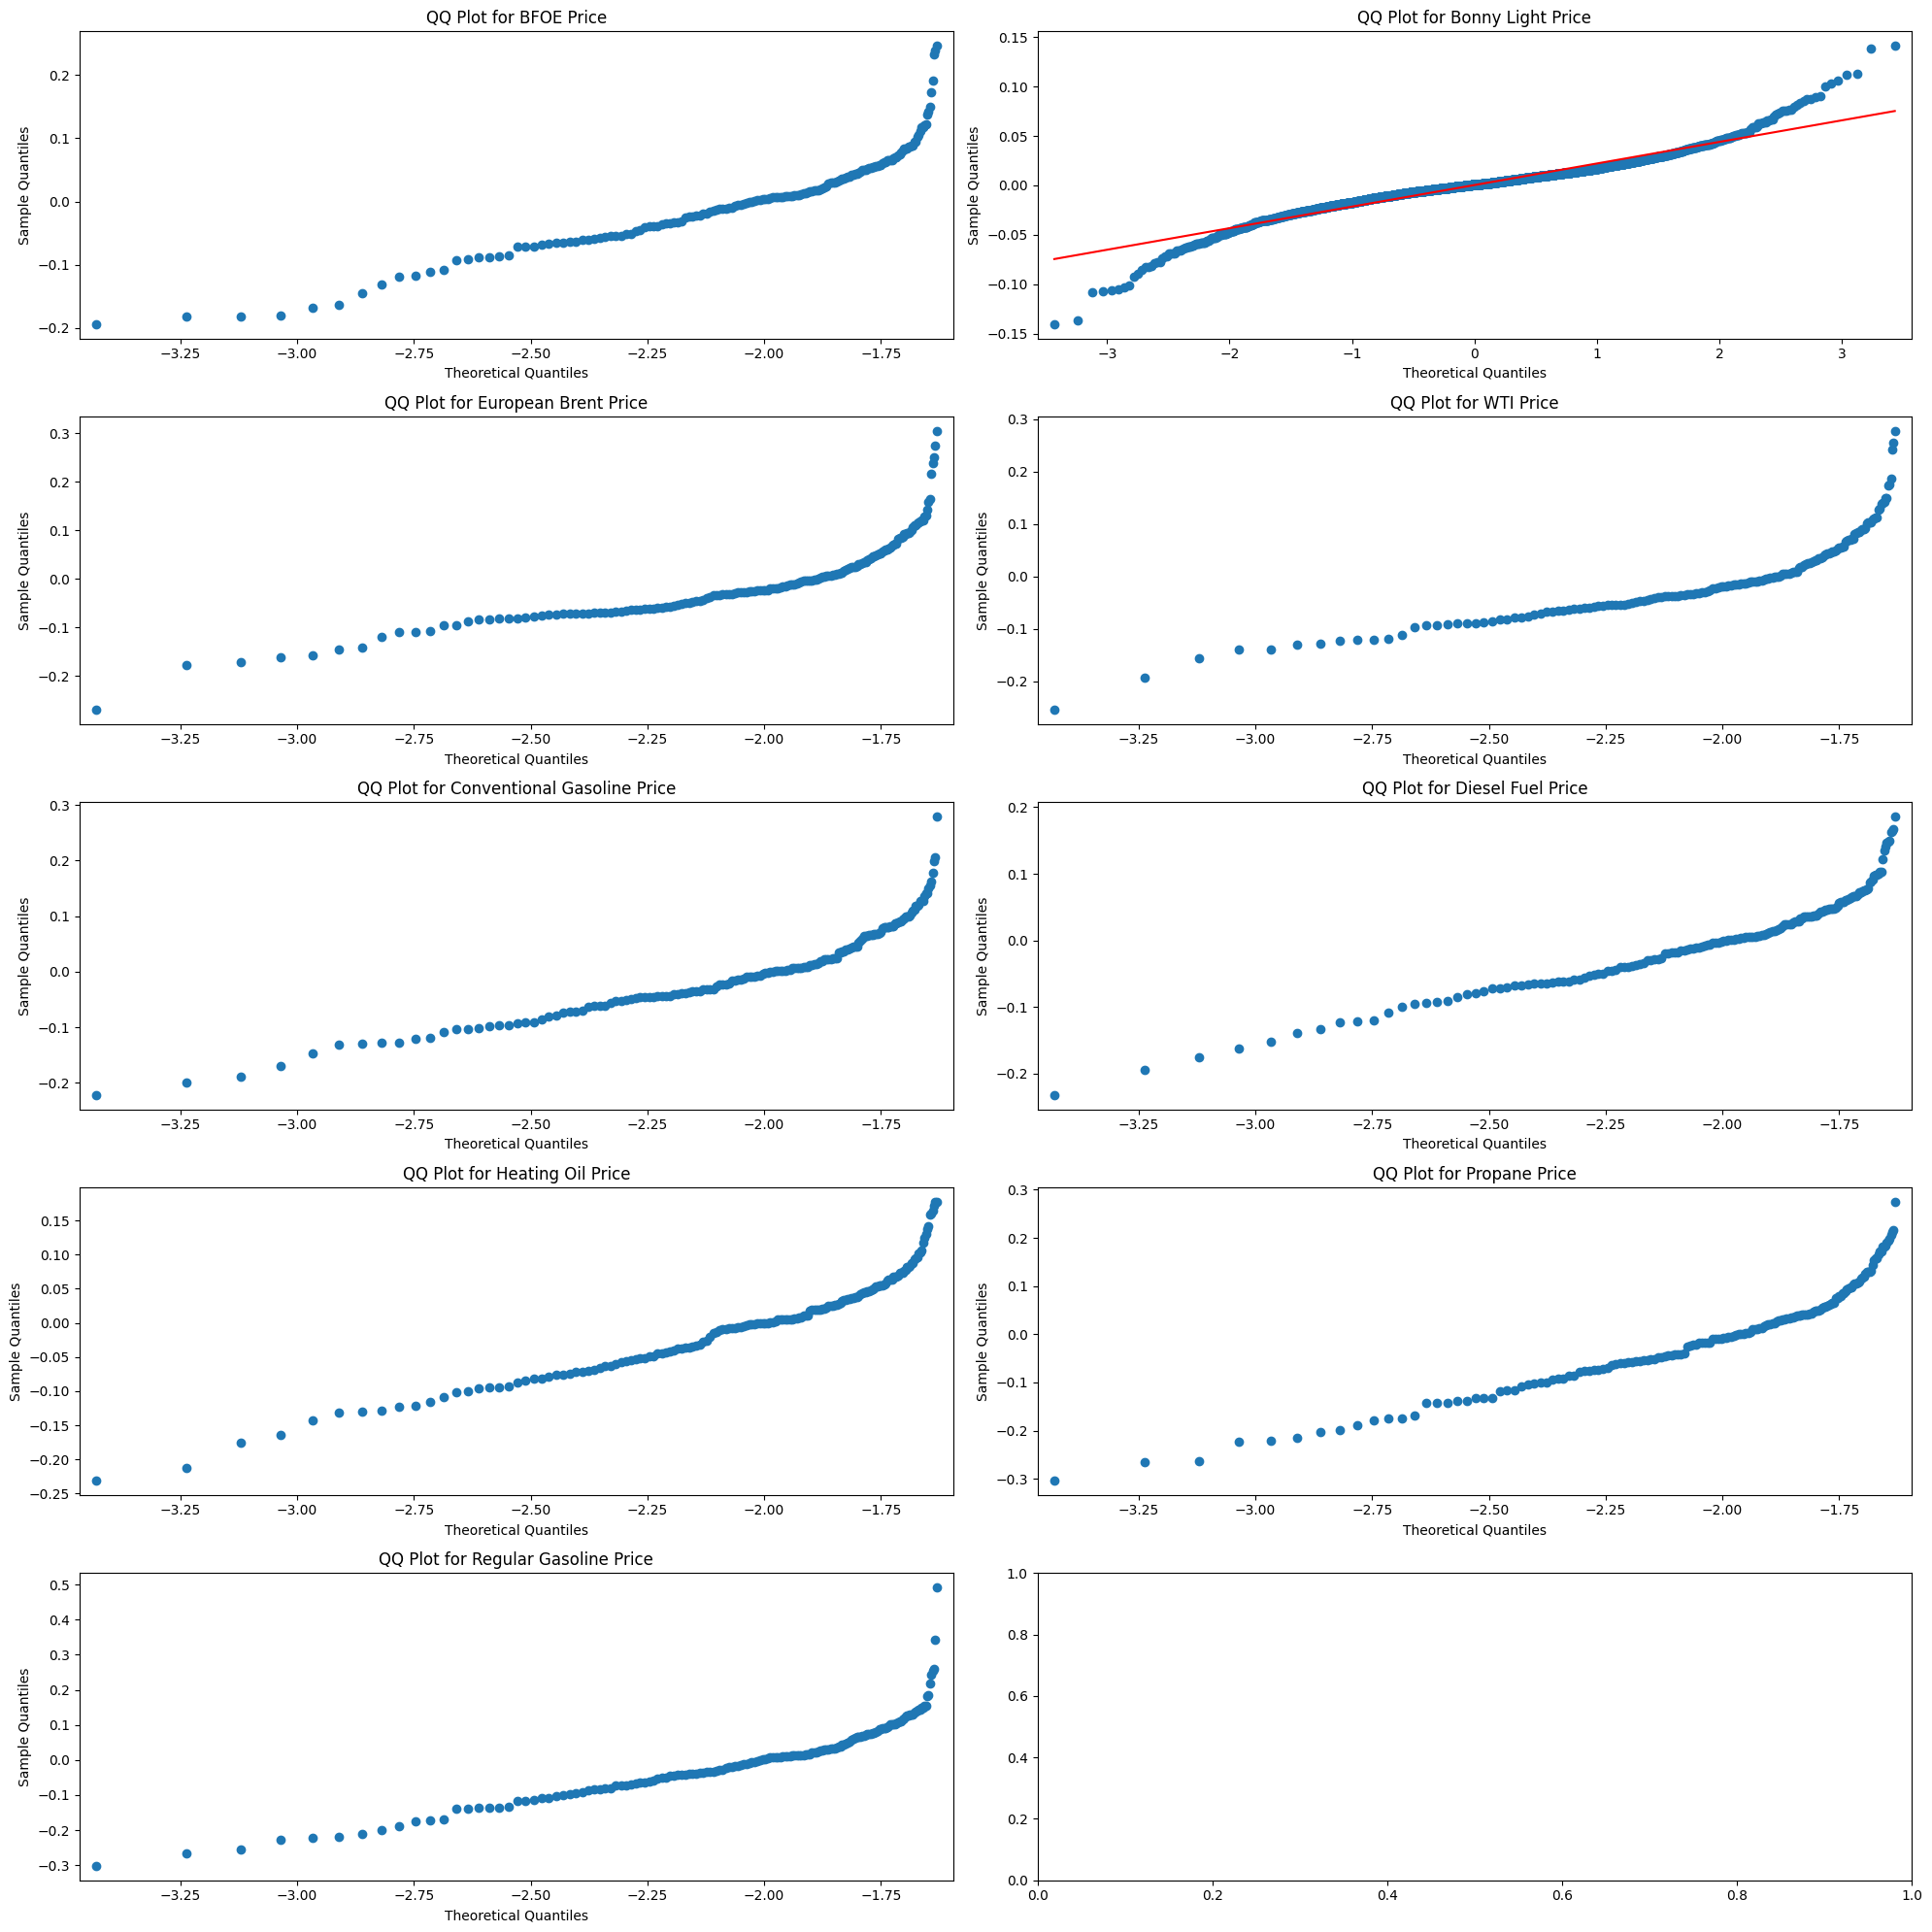

In [ ]:
# Reset index
BFOE_df_processed.reset_index(drop=True, inplace=True)
Bonny_Light_df_processed.reset_index(drop=True, inplace=True)
Europe_Brent_df_processed.reset_index(drop=True, inplace=True)
WTI_df_processed.reset_index(drop=True, inplace=True)
Conventional_Gasoline_df_processed.reset_index(drop=True, inplace=True)
Diesel_Fuel_df_processed.reset_index(drop=True, inplace=True)
Heating_Oil_df_processed.reset_index(drop=True, inplace=True)
Propane_df_processed.reset_index(drop=True, inplace=True)
Regular_Gasoline_df_processed.reset_index(drop=True, inplace=True)

# Concatenate the preprocessed DataFrames
all_processed_data = pd.concat([BFOE_df_processed, Bonny_Light_df_processed, Europe_Brent_df_processed,
                                WTI_df_processed, Conventional_Gasoline_df_processed,
                                Diesel_Fuel_df_processed, Heating_Oil_df_processed, Propane_df_processed,
                                Regular_Gasoline_df_processed], axis=1)

# Q-Q Analysis
price_columns = ['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                 'Crude Oil Price in USD',
                 'Europe Brent Spot Price FOB Dollars per Barrel',
                 'Cushing OK WTI Spot Price FOB Dollars per Barrel',
                 'New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
                 'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)',
                 'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)',
                 'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)',
                 'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)']

# Subplot Titles
subplot_titles = [
    'BFOE Price', 'Bonny Light Price', 'European Brent Price', 'WTI Price',
    'Conventional Gasoline Price', 'Diesel Fuel Price', 'Heating Oil Price',
    'Propane Price', 'Regular Gasoline Price'
]

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()

# Plot Q-Q plots for each price column with custom titles
for i, col in enumerate(price_columns):
    sm.qqplot(all_processed_data[col], line='s', ax=axs[i])
    axs[i].set_title('QQ Plot for {}'.format(subplot_titles[i]))

plt.tight_layout()
plt.show()


#**STEP 4:Statistical Analysis**


*   Use statistical techniques to identify correlations between crude oil prices and their refined products.

In [ ]:
# Concatenate the preprocessed DataFrames
all_processed_data = pd.concat([BFOE_df_processed, Bonny_Light_df_processed, Europe_Brent_df_processed, WTI_df_processed,
                                Conventional_Gasoline_df_processed, Diesel_Fuel_df_processed, Heating_Oil_df_processed, Propane_df_processed, Regular_Gasoline_df_processed], axis=1)

# Extract the columns related to crude oil prices and refined products
price_columns = ['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                 'Crude Oil Price in USD',
                 'Europe Brent Spot Price FOB Dollars per Barrel',
                 'Cushing OK WTI Spot Price FOB Dollars per Barrel']

product_columns = ['New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
                   'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)',
                   'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)',
                   'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)',
                   'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)']

# Rename columns in the correlation matrix
short_price_columns = ['BFOE', 'Crude Oil USD', 'Europe Brent', 'WTI']
short_product_columns = ['Conventional Gasoline', 'Diesel Fuel', 'Heating Oil', 'Propane', 'Regular Gasoline']

# Calculate the correlation matrix
correlation_matrix = all_processed_data[price_columns + product_columns].corr()

# Rename the columns in the correlation matrix
correlation_matrix.columns = short_price_columns + short_product_columns
correlation_matrix.index = short_price_columns + short_product_columns

# Display the correlation matrix
print("Correlation Matrix between Crude Oil Prices and Refined Products:")
print(correlation_matrix)


Correlation Matrix between Crude Oil Prices and Refined Products:
                           BFOE  Crude Oil USD  Europe Brent       WTI  \
BFOE                   1.000000       0.119910      0.013831 -0.001631   
Crude Oil USD          0.119910       1.000000     -0.067675 -0.070701   
Europe Brent           0.013831      -0.067675      1.000000  0.938269   
WTI                   -0.001631      -0.070701      0.938269  1.000000   
Conventional Gasoline  0.812887       0.019434     -0.038306 -0.045577   
Diesel Fuel            0.819510       0.057232     -0.011839 -0.031308   
Heating Oil            0.804920       0.071903     -0.014091 -0.028209   
Propane                0.606539       0.089097     -0.148449 -0.145016   
Regular Gasoline       0.630438      -0.000634     -0.021318 -0.015016   

                       Conventional Gasoline  Diesel Fuel  Heating Oil  \
BFOE                                0.812887     0.819510     0.804920   
Crude Oil USD                       0.019434 

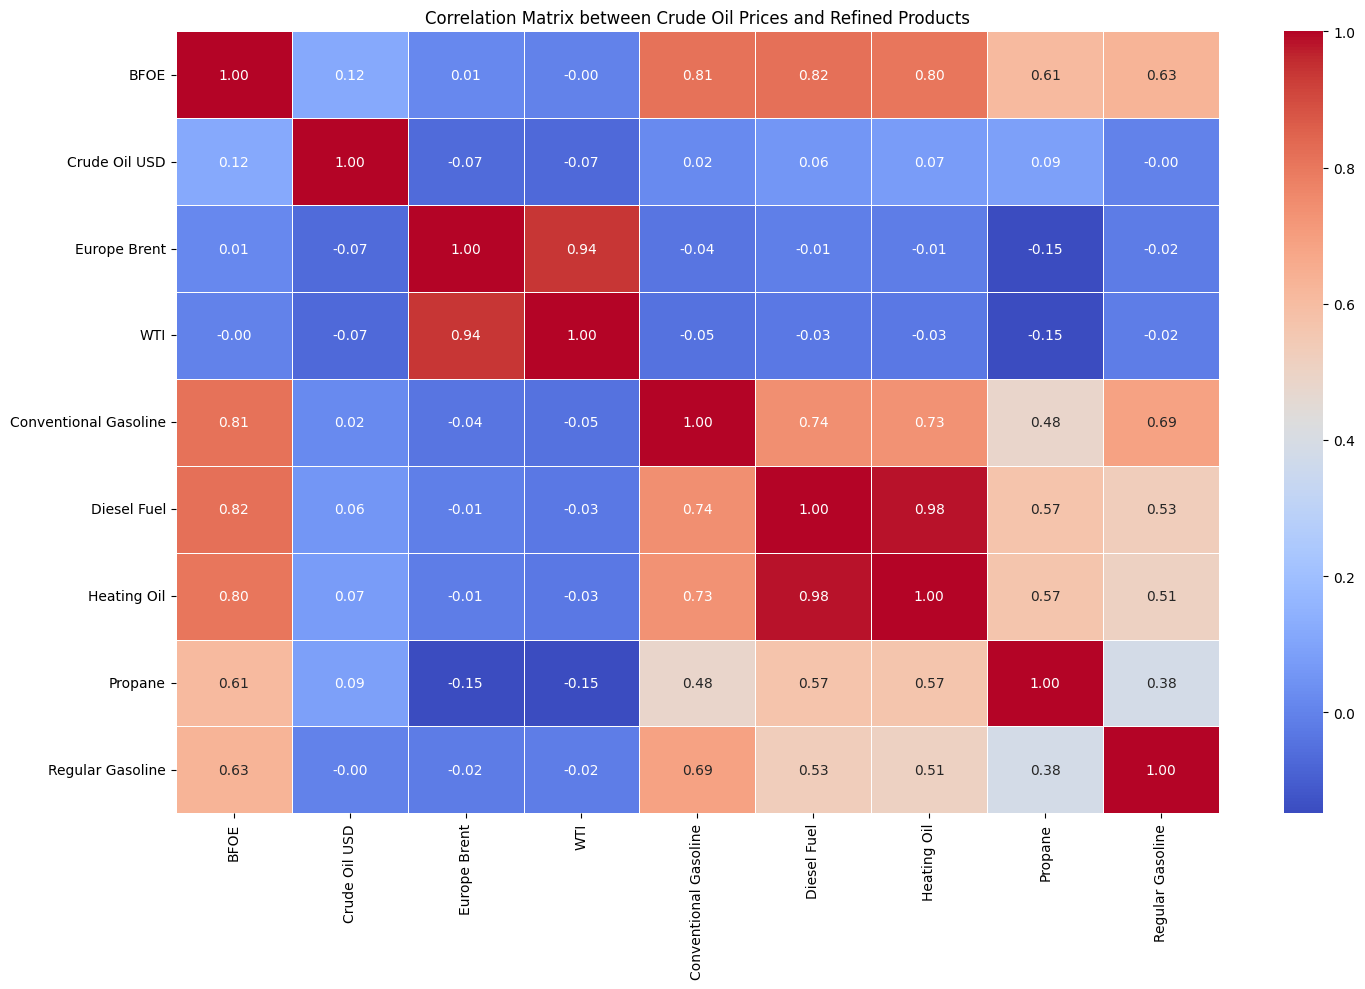

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add title and adjust plot
plt.title('Correlation Matrix between Crude Oil Prices and Refined Products')
plt.tight_layout()

# Show plot
plt.show()

#**STEP 5:Model Development via Multivariate Techniques**


*   Use advanced statistical methodologies such as multivariate GARCH models, and Principal Component Analysis (PCA) to develop dynamic models for price relationship analysis.

In [ ]:
# PCA Technique

# Extract the relevant columns for PCA
crude_and_refined_data = pd.concat([all_processed_data[price_columns], all_processed_data[product_columns]], axis=1)

# Check for infinity or very large values and replace them with NaN
crude_and_refined_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the data and transform it
X_imputed = imputer.fit_transform(crude_and_refined_data)

# Create a PCA object
pca = PCA(n_components=7)

# Fit the PCA object to the data
pca.fit(X_imputed)

# Transform the data using the PCA object
X_transformed = pca.transform(X_imputed)

# Print the transformed data
print(X_transformed)

[[-1.42421351e-02 -1.43805785e-03 -2.38531543e-05 ...  1.70840158e-03
  -3.04804229e-03 -2.50744532e-03]
 [-4.26522251e-02 -5.01106858e-02  8.74569775e-03 ...  1.33918178e-02
  -1.09891013e-02  4.02781891e-02]
 [ 8.77618597e-02 -1.41858284e-02 -1.14420025e-02 ... -1.15870216e-01
   1.16014021e-02  1.73665479e-02]
 ...
 [-7.78696307e-06  2.78000267e-05 -9.31392854e-04 ... -4.93830192e-06
   2.86422420e-07  8.87299219e-06]
 [ 1.21200145e-04 -4.32693366e-04  1.44966590e-02 ...  7.68621736e-05
  -4.45802021e-06 -1.38103639e-04]
 [-9.58914948e-06  3.42339638e-05 -1.14695103e-03 ... -6.08120456e-06
   3.52710983e-07  1.09265252e-05]]


Iteration:      1,   Func. Count:      5,   Neg. LLF: 64342.54827978571
Iteration:      2,   Func. Count:     11,   Neg. LLF: -192.73917684414835
Iteration:      3,   Func. Count:     18,   Neg. LLF: -198.77466282623317
Iteration:      4,   Func. Count:     23,   Neg. LLF: -199.5243799420191
Iteration:      5,   Func. Count:     28,   Neg. LLF: -199.2397015479167
Iteration:      6,   Func. Count:     33,   Neg. LLF: -196.8271200141793
Iteration:      7,   Func. Count:     38,   Neg. LLF: -200.89616199087294
Iteration:      8,   Func. Count:     42,   Neg. LLF: -200.89635554163365
Iteration:      9,   Func. Count:     46,   Neg. LLF: -200.89637174545692
Iteration:     10,   Func. Count:     50,   Neg. LLF: -200.89637573263025
Iteration:     11,   Func. Count:     53,   Neg. LLF: -200.89637573234808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -200.89637573263025
            Iterations: 11
            Function evaluations: 53
            Gradi

<ipython-input-11-935e690a850c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_prices_data.dropna(inplace=True)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002411. Parameter
estimat


Iteration:      8,   Func. Count:     41,   Neg. LLF: -189.85852084415257
Iteration:      9,   Func. Count:     45,   Neg. LLF: -189.85853946522803
Iteration:     10,   Func. Count:     48,   Neg. LLF: -189.85853946534172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.85853946522803
            Iterations: 10
            Function evaluations: 48
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -65.23061804511902
Iteration:      2,   Func. Count:     13,   Neg. LLF: -184.60221748028152
Iteration:      3,   Func. Count:     18,   Neg. LLF: -189.3498873717037
Iteration:      4,   Func. Count:     22,   Neg. LLF: -189.34138257214283
Iteration:      5,   Func. Count:     27,   Neg. LLF: -189.3584646298118
Iteration:      6,   Func. Count:     31,   Neg. LLF: -189.3585648126163
Iteration:      7,   Func. Count:     35,   Neg. LLF: -189.3585803519751
Iteration:      8,   Func. Count:     38,   Neg. LLF:

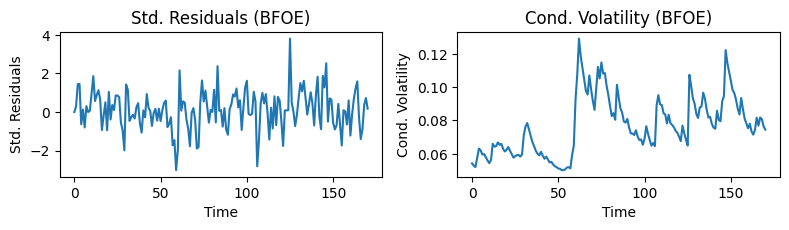

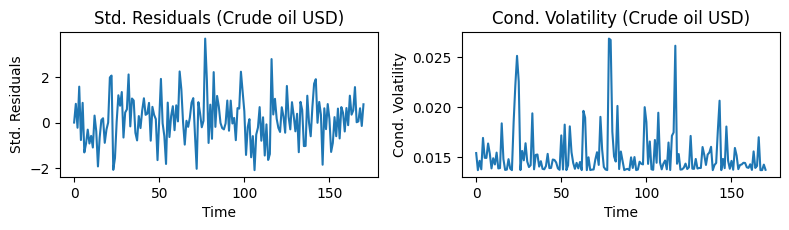

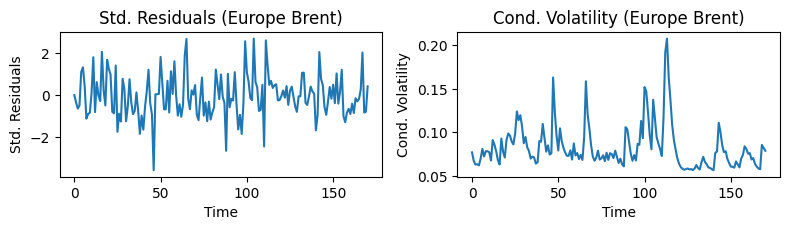

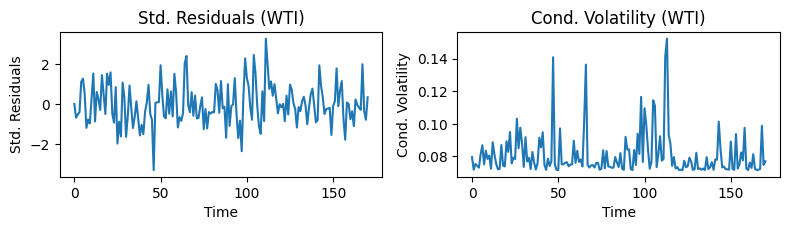

Summary for Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price:
                                                       Zero Mean - GARCH Model Results                                                        
Dep. Variable:     Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price   R-squared:                       0.000
Mean Model:                                                                                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                                                                                      GARCH   Log-Likelihood:                200.896
Distribution:                                                                                  Normal   AIC:                          -395.793
Method:                                                                            Maximum Likelihood   BIC:                          -386.368
                                              

In [ ]:
#GARCH model

# Define the oil prices for the columns
short_names = {
    'Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price': 'BFOE',
    'Crude Oil Price in USD': 'Crude oil USD',
    'Europe Brent Spot Price FOB Dollars per Barrel': 'Europe Brent',
    'Cushing OK WTI Spot Price FOB Dollars per Barrel': 'WTI'
}

# Extract the relevant columns for GARCH modeling
oil_prices_data = all_processed_data[list(short_names.keys())]

# Drop rows with NaN values
oil_prices_data.dropna(inplace=True)

# Define a list to store the fitted models
fitted_models = []

# Fit separate GARCH models for each oil price series
for column in oil_prices_data.columns:
    oil_price_series = oil_prices_data[column]
    model = arch_model(oil_price_series, mean="Zero", vol="GARCH", p=1, q=1)
    model_fit = model.fit()
    fitted_models.append((column, model_fit))

# Plot the standardized residuals and conditional volatility with short names
for column, model_fit in fitted_models:
    # Plot the standardized residuals
    plt.figure(figsize=(8, 4))
    plt.subplot(2, 2, 1)
    plt.plot(model_fit.resid / model_fit.conditional_volatility)
    plt.title(f"Std. Residuals ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Std. Residuals")

    # Plot the conditional volatility
    plt.subplot(2, 2, 2)
    plt.plot(model_fit.conditional_volatility)
    plt.title(f"Cond. Volatility ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Cond. Volatility")

    plt.tight_layout()
    plt.show()

# Print summaries for each fitted model
for column, model_fit in fitted_models:
    print(f"Summary for {column}:")
    print(model_fit.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 216151.93340058168
Iteration:      2,   Func. Count:     11,   Neg. LLF: -169.7946401953886
Iteration:      3,   Func. Count:     18,   Neg. LLF: -188.39912759647365
Iteration:      4,   Func. Count:     23,   Neg. LLF: -189.12811011292877
Iteration:      5,   Func. Count:     28,   Neg. LLF: -189.12827243253787
Iteration:      6,   Func. Count:     32,   Neg. LLF: -189.1283264476175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -189.1283264476541
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2183.2382062697484
Iteration:      2,   Func. Count:     11,   Neg. LLF: -203.43405284847614
Iteration:      3,   Func. Count:     18,   Neg. LLF: -212.23280544118336
Iteration:      4,   Func. Count:     23,   Neg. LLF: -212.83739834417196
Iteration:      5,   Func. Count:     28,   Neg. LLF: -2

<ipython-input-12-923438ad24e1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_products_data.dropna(inplace=True)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006699. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005208. Parameter
es

Iteration:      9,   Func. Count:     48,   Neg. LLF: -147.1544433481535
Iteration:     10,   Func. Count:     51,   Neg. LLF: -147.15444334806247
Optimization terminated successfully    (Exit mode 0)
            Current function value: -147.1544433481535
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 336.0154361587588
Iteration:      2,   Func. Count:     13,   Neg. LLF: -125.82674879823628
Iteration:      3,   Func. Count:     19,   Neg. LLF: -134.16482847596265
Iteration:      4,   Func. Count:     24,   Neg. LLF: -139.8965529406094
Iteration:      5,   Func. Count:     28,   Neg. LLF: -139.9018026304887
Iteration:      6,   Func. Count:     32,   Neg. LLF: -139.9049399219843
Iteration:      7,   Func. Count:     36,   Neg. LLF: -139.90553134311162
Iteration:      8,   Func. Count:     40,   Neg. LLF: -139.90576918780067
Iteration:      9,   Func. Count:     44,   Neg. LLF: -1

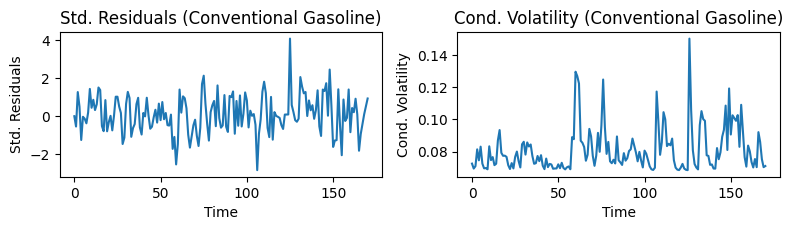

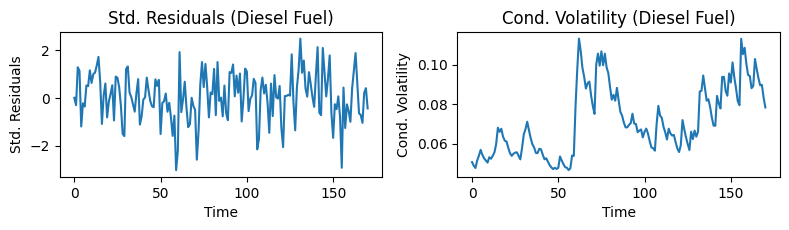

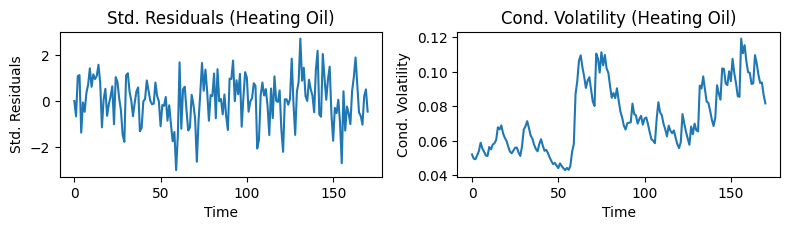

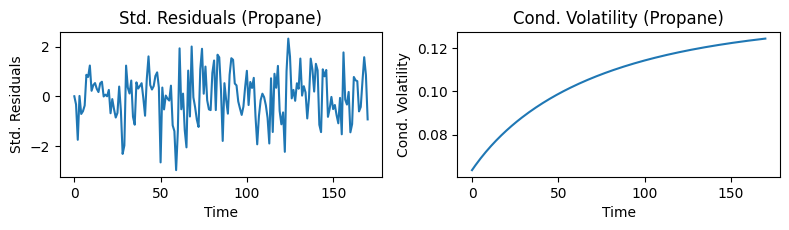

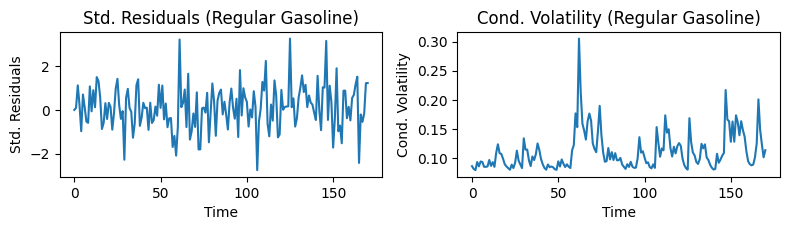

Summary for New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon):
                                                       Zero Mean - GARCH Model Results                                                       
Dep. Variable:     New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)   R-squared:                       0.000
Mean Model:                                                                                Zero Mean   Adj. R-squared:                  0.006
Vol Model:                                                                                     GARCH   Log-Likelihood:                189.128
Distribution:                                                                                 Normal   AIC:                          -372.257
Method:                                                                           Maximum Likelihood   BIC:                          -362.832
                                                     

In [ ]:
#GARCH model

# Define refined product price names for the columns
short_names = {
    'New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)': 'Conventional Gasoline',
    'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)': 'Diesel Fuel',
    'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)': 'Heating Oil',
    'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)': 'Propane',
    'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)': 'Regular Gasoline'
}

# Extract the relevant columns for GARCH modeling
refined_products_data = all_processed_data[list(short_names.keys())]

# Drop rows with NaN values
refined_products_data.dropna(inplace=True)

# Define a list to store the fitted models
fitted_models = []

# Fit separate GARCH models for each refined product price series
for column in refined_products_data.columns:
    refined_product_series = refined_products_data[column]
    model = arch_model(refined_product_series, mean="Zero", vol="GARCH", p=1, q=1)
    model_fit = model.fit()
    fitted_models.append((column, model_fit))

# Plot the standardized residuals and conditional volatility with short names
for column, model_fit in fitted_models:
    # Plot the standardized residuals
    plt.figure(figsize=(8, 4))
    plt.subplot(2, 2, 1)
    plt.plot(model_fit.resid / model_fit.conditional_volatility)
    plt.title(f"Std. Residuals ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Std. Residuals")

    # Plot the conditional volatility
    plt.subplot(2, 2, 2)
    plt.plot(model_fit.conditional_volatility)
    plt.title(f"Cond. Volatility ({short_names[column]})")
    plt.xlabel("Time")
    plt.ylabel("Cond. Volatility")

    plt.tight_layout()
    plt.show()

# Print summaries for each fitted model
for column, model_fit in fitted_models:
    print(f"Summary for {column}:")
    print(model_fit.summary())


#**STEP 6:Result Interpretation**

The temporal patterns and distributional characteristics of crude oil and refined product prices across different global markets were obtained through EDA. Time series plots were used to visualize the trends, seasonal patterns, and outliers in the data sets. Furthermore Q-Q analysis was conducted to assess the distributional characteristics of energy product prices. Statistical techniques were applied to identify correlations between crude oil prices and their refined products within each market. Quantitative measures were employed to quantify the strength and direction of the relationships between crude oil and refined product prices.

The relationship between crude oil prices and refined product prices were calculated through the correlation matrix. BFOE shows a moderate positive correlation with all the refined product prices. Crude Oil prices  have weak correlations with refined products, which indicates limited influence on their prices. Both Europe Brent and WTI prices follow the same moderate positive pattern of correlations with refined products. Conventional Gasoline, Diesel Fuel, Heating Oil, and Regular Gasoline. All refined product prices except Propane show positive correlations with each other, indicating similar price movements. Propane exhibits weaker correlations with other refined products which suggest relatively independent price dynamics. Moreover, the positive correlations between crude oil prices and refined product prices suggest that changes in crude oil prices influence the prices of refined products. This relationship is expected due to the role of crude oil as a primary input in the production of refined products. Comparatively,  strong correlations are observed between crude oil prices and Conventional Gasoline, Diesel Fuel, and Heating Oil. This indicates a relatively closer relationship between these products and crude oil benchmarks.

GARCH models and PCA, were applied to develop dynamic models for analyzing price relationships across different markets. These models incorporated time-varying volatility and conditional correlations, allowing for a comprehensive assessment of the complex interactions between crude oil and refined product prices.


#**STEP 7:Discussion**

Analyzing the relationship between crude oil and refined product prices provides valuable insights into market trends, demand-supply dynamics, and price drivers in the energy sector. This is valuable  to make informed decisions regarding investments, trading activities, and long-term strategic planning. Furthermore, accurate forecasting of future price movements helps stakeholders anticipate market trends and adjust their strategies accordingly. Understanding the relationships between these prices across different global markets informs policymakers about potential market distortions, supply chain vulnerabilities, and the effectiveness of regulatory interventions. This helps in formulating appropriate policies and regulations to ensure market stability, energy security, and sustainable development.